# Airplane, Leopard, or Dolphin?

### Using the Visual Bag of Word Technique to determine the subject of a photo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import cv2
import os
import random
from scipy.spatial.distance import cdist
from scipy import stats
from sklearn import svm

# Reads all images in given directory
def read_images(image_dir, N=None, resize_val=None):
    img_names = os.listdir(image_dir)
    M = len(img_names)
    imgs = list()
    if (N is not None):
        img_names = img_names[:N]
    
    for i, img_name in enumerate(img_names):
        img_file = os.path.join(image_dir, img_name)
        img = cv2.imread(img_file)
        if img is not None:
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            if (resize_val is not None):
                img_gray = cv2.resize(img_gray, (0, 0), fx=0.5, fy=0.5)
            imgs.append(img_gray)
        
    return imgs

airplanes = read_images('..\\OIDv4_ToolKit\\OID\\Dataset\\train\\Airplane', resize_val=0.5, N=600)
dolphins = read_images('..\\OIDv4_ToolKit\\OID\\Dataset\\train\\Dolphin', resize_val=0.5, N=600)
leopards = read_images('..\\OIDv4_ToolKit\\OID\\Dataset\\train\\Leopard', resize_val=0.5, N=600)

In [3]:
def plot_img_and_keypoints(img):
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))
    ax1.imshow(img, cmap='gray')
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    img_kp = cv2.drawKeypoints(img, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    ax2.imshow(img_kp)

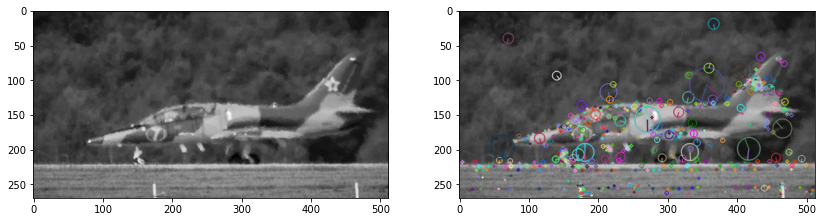

In [4]:
plot_img_and_keypoints(airplanes[4])

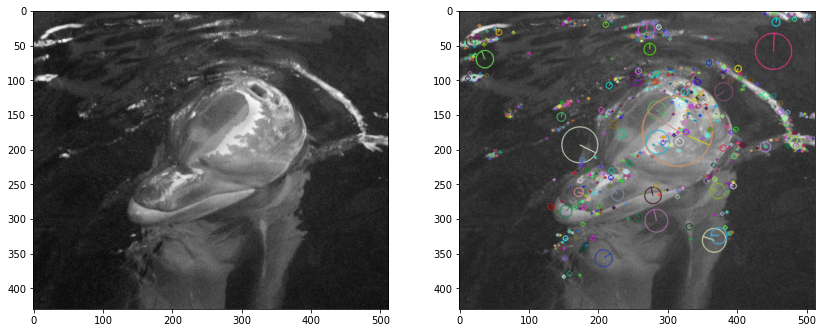

In [5]:
plot_img_and_keypoints(dolphins[0])

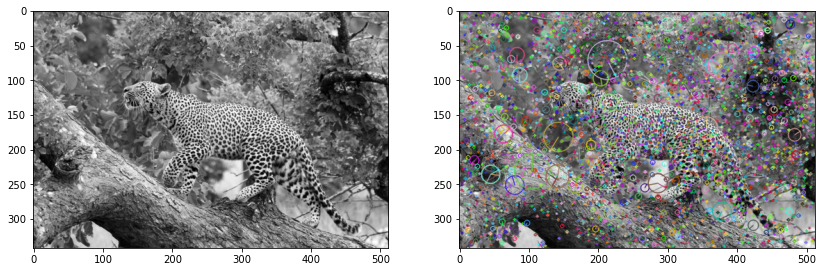

In [6]:
plot_img_and_keypoints(leopards[1])

In [7]:
sift = cv2.SIFT_create()

def get_set_descriptors(image_set, sift, min_kps=70):
    image_set_filtered = []
    keypoints = []
    descips = []
    for img in image_set:
        kp, des = sift.detectAndCompute(img,None)
        if (len(kp) > min_kps):
            image_set_filtered.append(img)
            descips.append(des)
            keypoints.append(kp)
    
    return image_set_filtered, keypoints, descips
        
airplanes_imgs, airplanes_kp, airplanes_des = get_set_descriptors(airplanes, sift)
dolphins_imgs, dolphins_kp, dolphins_des = get_set_descriptors(dolphins, sift)
leopards_imgs, leopards_kp, leopards_des = get_set_descriptors(leopards, sift)

In [8]:
print(len(airplanes_imgs), len(dolphins_imgs), len(leopards_imgs))
print(min(map(len, airplanes_kp)), min(map(len, dolphins_kp)), min(map(len, leopards_kp)))

563 579 600
72 72 108


In [29]:
def argsort(seq):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=seq.__getitem__)

def get_top_kp_desc(keypoints, descriptors, n):
    top_kp = []
    top_desc = []
    for keypoint, descriptor in zip(keypoints, descriptors):
        kp_sorted_idx = argsort([kp.size for kp in keypoint])
        top_kp_idx = kp_sorted_idx[:n]
        top_kp.append([keypoint[i] for i in top_kp_idx])
        top_desc.append(descriptor[top_kp_idx,:])
    return top_kp, top_desc

min_kp = 72
kpa, desca = get_top_kp_desc(airplanes_kp, airplanes_des, min_kp)
kpd, descd = get_top_kp_desc(dolphins_kp, dolphins_des, min_kp)
kpl, descl = get_top_kp_desc(leopards_kp, leopards_des, min_kp)

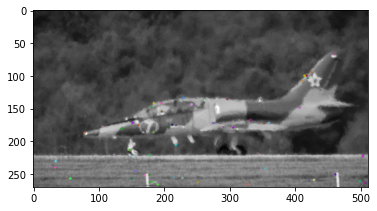

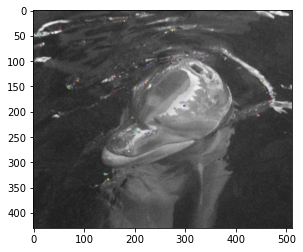

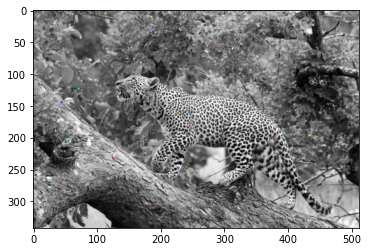

In [30]:
imga=cv2.drawKeypoints(airplanes[4],kpa[4],airplanes[4],flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgd=cv2.drawKeypoints(dolphins[0], kpd[0],dolphins[0],flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgl=cv2.drawKeypoints(leopards[1], kpl[1],leopards[1],flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(imga)
plt.show()
plt.imshow(imgd)
plt.show()
plt.imshow(imgl)

In [31]:
train_size = 450
desca_train, desca_test, kpa_train, kpa_test, imga_train, imga_test = train_test_split(desca, kpa, airplanes_imgs, train_size=train_size)
descd_train, descd_test, kpd_train, kpd_test, imgd_train, imgd_test = train_test_split(descd, kpd, dolphins_imgs, train_size=train_size)
descl_train, descl_test, kpl_train, kpl_test, imgl_train, imgl_test  = train_test_split(descl, kpl, leopards_imgs, train_size=train_size)
print(len(desca_train), len(desca_test))
print(len(descd_train), len(descd_test))
print(len(descl_train), len(descl_test))

450 113
450 129
450 150


C:\Users\mills\anaconda3\envs\cmsc426\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [32]:
desca_train_flat = np.vstack(desca_train)
descd_train_flat = np.vstack(descd_train)
descl_train_flat = np.vstack(descl_train)
desca_test_flat = np.vstack(desca_test)
descd_test_flat = np.vstack(descd_test)
descl_test_flat = np.vstack(descl_test)

In [33]:
train_set = np.concatenate((desca_train_flat, descd_train_flat, descl_train_flat))
train_keypoints = [kpa_train, kpd_train, kpl_train]
train_images = [imga_train, imgd_train, imgl_train]
test_set = np.concatenate((desca_test_flat, descd_test_flat, descl_test_flat))
test_keypoints = [kpa_test, kpd_test, kpl_test]
test_images = [imga_test, imgd_test, imgl_test]
# Print shape for check
print(train_set.shape)
print(test_set.shape)

(97200, 128)
(28224, 128)


In [34]:
k = 400
kmeans = KMeans(n_clusters=k)
train_labels = kmeans.fit_predict(train_set)

C:\Users\mills\anaconda3\envs\cmsc426\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [16]:
img_class_label = {'airplane': 0, 'dolphin': 1, 'leopard': 2}

# Given the cluster labels, name of image class, image number in class, number of images in class and number of keypoints in image
# Returns the cluster labels for all the keypoints in the image
def get_img_cluster_labels(labels, img_class, img_num, img_per_class, kp_per_img):
    img_class_num = img_class_label.get(img_class)
    if img_class_num is None or img_num > img_per_class:
        raise ValueError('Bad arguments')
    start_idx = img_class_num * img_per_class + img_num * kp_per_img
    end_idx = start_idx + kp_per_img
    return labels[start_idx:end_idx]

# Given the overall keypoint index, number of images per class and number of keypoints per image
# Returns the class number, image number within class, and keypoint number within the image
def get_class_imgnum_from_index(keypoint_index, img_per_class, kp_per_img):
    image_index = keypoint_index // kp_per_img
    class_num = image_index // img_per_class
    image_num = image_index - class_num * img_per_class
    kp_num = keypoint_index % kp_per_img
    if class_num > 2 or image_num < 0 or image_num > img_per_class:
        raise ValueError('Bad arguments; Class num or image num outside range')
    return class_num, image_num, kp_num


<BarContainer object of 58 artists>

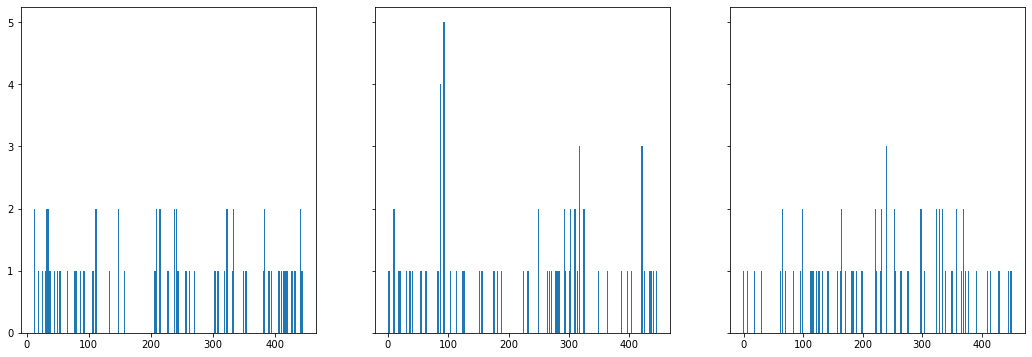

In [17]:
img1_labels = get_img_cluster_labels(train_labels, 'airplane', 4, train_size, min_kp)
img1_hist = np.unique(img1_labels, return_counts=True)
img2_labels = get_img_cluster_labels(train_labels, 'dolphin', 0, train_size, min_kp)
img2_hist = np.unique(img2_labels, return_counts=True)
img3_labels = get_img_cluster_labels(train_labels, 'leopard', 1, train_size, min_kp)
img3_hist = np.unique(img3_labels, return_counts=True)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
ax1.bar(img1_hist[0], img1_hist[1], width=2)
ax2.bar(img2_hist[0], img2_hist[1], width=2)
ax3.bar(img3_hist[0], img3_hist[1], width=2)

In [18]:
# Returns the image to the closest of each cluster centroid
def get_cluster_images(labels, centroids, descriptors, keypoints, images, patch_area=30):
    indices = np.arange(descriptors.shape[0])
    cluster_imgs = []
    for center_num, centroid in enumerate(centroids):
        # Get all descriptors within cluster
        kp_indices = np.nonzero(labels == center_num)
        cluster_descs = descriptors[kp_indices]

        # Find descriptor closest to the centroid point
        dists = np.linalg.norm(cluster_descs - centroid, axis=1)
        min_idx = np.argmin(dists)
        descriptor_index = indices[kp_indices][min_idx]

        # Find the class, image, and keypoints that this descriptor came from
        i_class, i_image, i_kp = get_class_imgnum_from_index(descriptor_index, train_size, min_kp)
        image = images[i_class][i_image]
        keypoint = keypoints[i_class][i_image][i_kp]
        
        # Take a small snippet from the keypoint images around the keypoint location
        x, y = keypoint.pt
        image_padded = np.pad(image, patch_area, mode='constant')
        x, y = x + patch_area, y + patch_area
        patch = image_padded[round(y-patch_area):round(y+patch_area),round(x-patch_area):round(x+patch_area)]
        cluster_imgs.append(patch)

    return np.asarray(cluster_imgs)

cluster_images = get_cluster_images(train_labels, kmeans.cluster_centers_, train_set, train_keypoints, train_images)


C:\Users\mills\anaconda3\envs\cmsc426\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


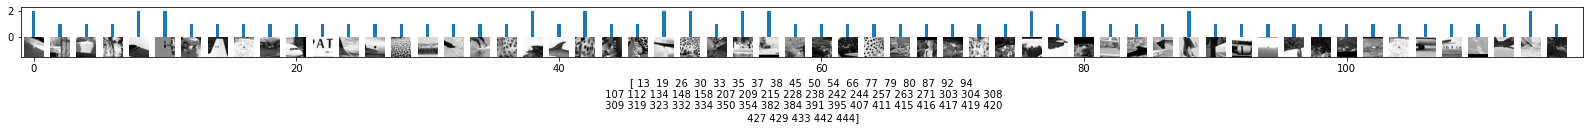

In [19]:
def plot_vocabulary(images, labels, class_name, img_num):
    img_labels = get_img_cluster_labels(labels, class_name, img_num, train_size, min_kp)
    cluster_nums, counts = np.unique(img_labels, return_counts=True)
    plt.figure(figsize=(28, 18))
    plt.bar(range(0, 2 * len(cluster_nums), 2), counts, width=0.25)
    for i, cluster_num in enumerate(cluster_nums):
        plt.imshow(images[cluster_num], cmap='gray', extent = (-.75 + 2*i, .75 + 2*i, -1.5, .0))
    plt.xlim(-1, 2 * len(cluster_nums))
    plt.ylim(-1.5, max(counts) * 1.15)
    plt.xlabel(cluster_nums)
    plt.show()
    
plot_vocabulary(cluster_images, train_labels, 'airplane', 4)

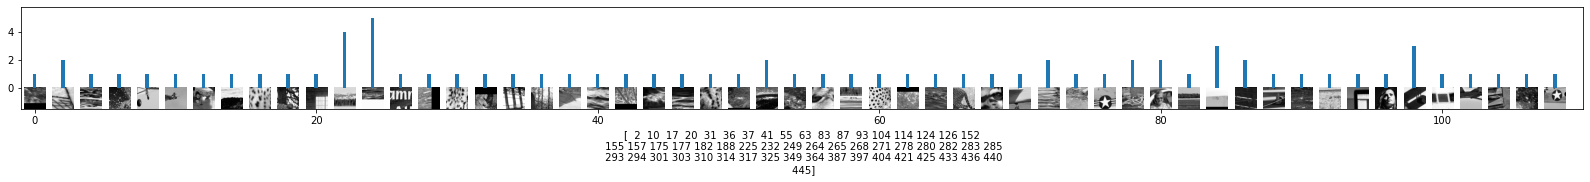

In [20]:
plot_vocabulary(cluster_images, train_labels, 'dolphin', 0)

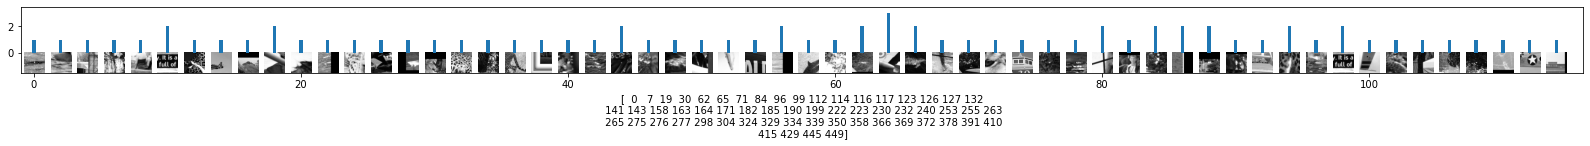

In [21]:
plot_vocabulary(cluster_images, train_labels, 'leopard', 1)

In [20]:
def plot_vocabulary_keypoints(cluster_images, labels, images, keypoints, class_name, img_num, patch_area=30):
    class_num = img_class_label[class_name]
    img = images[class_num][img_num]
    img_keypoints = keypoints[class_num][img_num]
    img_labels = get_img_cluster_labels(labels, class_name, img_num, train_size, min_kp)
    img_padded = np.pad(img, patch_area, mode='constant')
    for i, (label, keypoint) in enumerate(zip(img_labels, img_keypoints)):
        cluster_img = cluster_images[label]
        x, y = keypoint.pt
        x, y = x + patch_area, y + patch_area
        patch = img_padded[round(y-patch_area):round(y+patch_area),round(x-patch_area):round(x+patch_area)]
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(4, 4))
        ax1.imshow(cluster_img, cmap='gray')
        ax2.imshow(patch, cmap='gray')
    plt.show()

# plot_vocabulary_keypoints(cluster_images, train_labels, train_images, train_keypoints, 'airplane', 4)

### SVM & Prediction

In [22]:
def get_histograms_classes(labels, n, k, num_image_per_class, num_kp):
    histograms = np.zeros((n, k))
    class_labels = np.zeros(n, dtype=np.int16)
    labels_reshape = np.reshape(labels, (n, num_kp))
    j = 0

    for img_labels in labels_reshape:
        img_hist = np.bincount(img_labels, minlength=k)
        histograms[j,:] = img_hist
        j += 1

    if type(num_image_per_class) is tuple:
        airplane_size, dolphin_size, leopard_size = num_image_per_class
        class_labels[:airplane_size] = [img_class_label['airplane']] * airplane_size
        class_labels[airplane_size:(airplane_size + dolphin_size)] = [img_class_label['dolphin']] * dolphin_size
        class_labels[(airplane_size + dolphin_size):] = [img_class_label['leopard']] * leopard_size
    else:
        class_labels[:num_image_per_class] = [img_class_label['airplane']] * num_image_per_class
        class_labels[num_image_per_class:(2 * num_image_per_class)] = [img_class_label['dolphin']] * num_image_per_class
        class_labels[(2 * num_image_per_class):] = [img_class_label['leopard']] * num_image_per_class

    return histograms, class_labels


train_histograms, train_classes = get_histograms_classes(train_labels, 3 * train_size, k, train_size, min_kp)
    

In [23]:
shuffle_idx = np.arange(len(train_histograms))
np.random.shuffle(shuffle_idx)
train_histograms = train_histograms[shuffle_idx]
train_classes = train_classes[shuffle_idx]

In [24]:
classifier = svm.SVC(kernel='linear', decision_function_shape='ovr')
classifier.fit(train_histograms, train_classes)
print(classifier)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [26]:
test_img_sizes = (len(desca_test), len(descd_test), len(descl_test))
test_labels = kmeans.predict(test_set)

In [27]:
test_histograms, test_classes = get_histograms_classes(test_labels, sum(test_img_sizes), k, test_img_sizes, min_kp)

predictions = classifier.predict(test_histograms)

In [26]:
print(predictions.shape)
print(test_classes.shape)
print([len(desca_test), len(descd_test), len(descl_test)])

(392,)
(392,)
[113, 129, 150]


In [28]:
confusion_matrix = np.zeros((3,3))

for pred, real in zip(predictions, test_classes):
    confusion_matrix[real, pred] += 1

print("confusion matrix")
print("airplane, dolphin, leopard")
print(confusion_matrix)
print("accuracy: ", (confusion_matrix[0,0] + confusion_matrix[1,1] + confusion_matrix[2,2]) / np.sum(confusion_matrix))

confusion matrix
airplane, dolphin, leopard
[[ 66.  32.  15.]
 [ 48.  68.  13.]
 [ 13.  15. 122.]]
accuracy:  0.6530612244897959
